Import libraries

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.tree import export_graphviz
import graphviz

In [2]:
df = pd.read_csv('../../data/Student_performance_data.csv')
df.drop(columns=['StudentID', 'GPA'], inplace=True)
df.info()

categorical_columns = ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GradeClass']
for col in categorical_columns:
    df[col] = df[col].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2392 non-null   int64  
 1   Gender             2392 non-null   int64  
 2   Ethnicity          2392 non-null   int64  
 3   ParentalEducation  2392 non-null   int64  
 4   StudyTimeWeekly    2392 non-null   float64
 5   Absences           2392 non-null   int64  
 6   Tutoring           2392 non-null   int64  
 7   ParentalSupport    2392 non-null   int64  
 8   Extracurricular    2392 non-null   int64  
 9   Sports             2392 non-null   int64  
 10  Music              2392 non-null   int64  
 11  Volunteering       2392 non-null   int64  
 12  GradeClass         2392 non-null   float64
dtypes: float64(2), int64(11)
memory usage: 243.1 KB


In [3]:
targetColumn = df['GradeClass']
otherColumns = df.drop(columns=targetColumn.name)
xTrain, xTest, yTrain, yTest = train_test_split(otherColumns, targetColumn, stratify=targetColumn, test_size=0.2)

Train the model

In [10]:

rf = RandomForestClassifier(random_state=1)
searchSpace = {
    'max_depth': Integer(2, 6),
    'ccp_alpha': Real(0.0, 10.0),
    'n_estimators': Integer(10, 1000),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
}
rf = BayesSearchCV(estimator=rf, search_spaces=searchSpace, n_iter=20, cv=5, random_state=2)
rf.fit(xTrain, yTrain)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_iter=20,
              random_state=2,
              search_spaces={'ccp_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=1000, prior='uniform', transform='normalize')})

In [5]:
rf.score(xTest, yTest)

0.6555323590814196

In [6]:
rf.best_estimator_

RandomForestClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=10,
                       n_estimators=10, random_state=1)

Make the tree

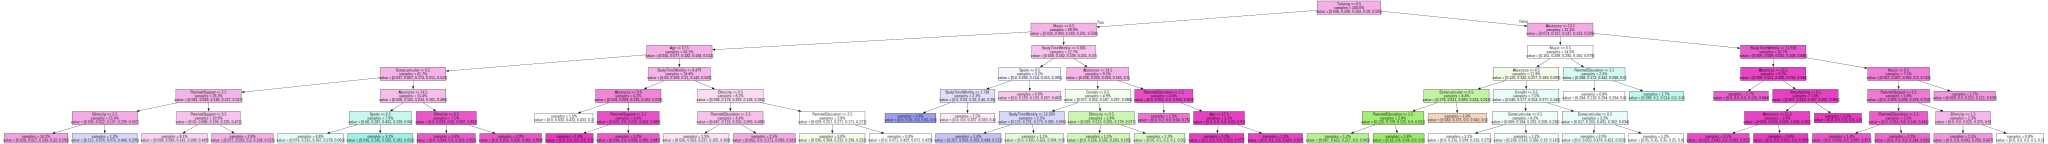

In [7]:
dot_data = export_graphviz(rf.best_estimator_[1],
                           feature_names=xTrain.columns,  
                           filled=True,  
                           max_depth=10, 
                           impurity=False, 
                           proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

Predict

In [8]:
x = 100
print(df['GradeClass'].loc[x])
# print(xTest.info())
rf.predict(otherColumns.loc[[x]])

4.0


array([4.])

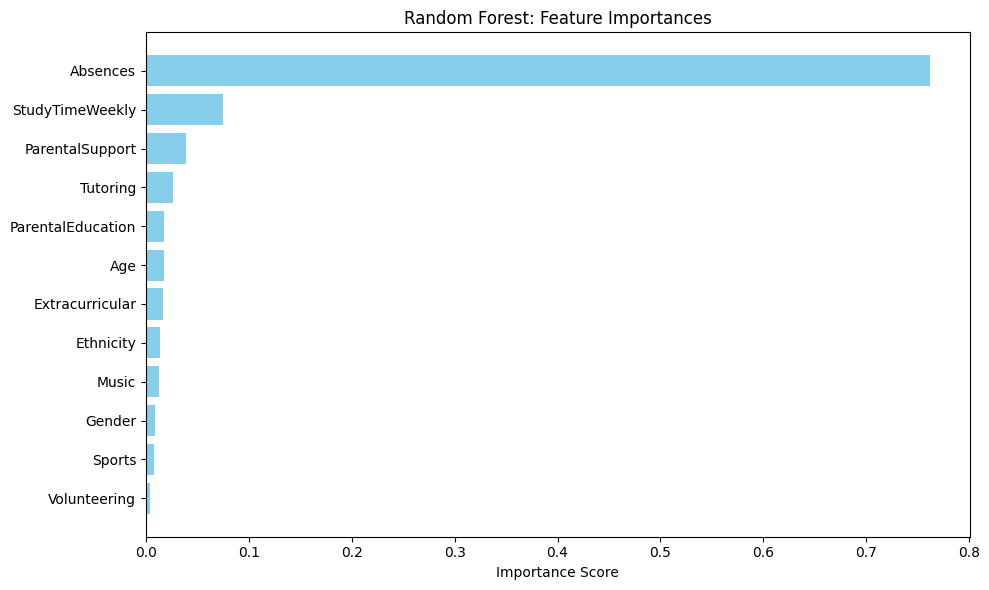

In [9]:

import matplotlib.pyplot as plt
 
best_rf_model = rf.best_estimator_  

importances = best_rf_model.feature_importances_
feature_names = xTrain.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Random Forest: Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
